* source: https://www.kaggle.com/discdiver/tpot-on-ames-housing-regression

TPOT is meant to be an assistant that gives you ideas on how to solve a particular machine learning problem by exploring pipeline configurations that you might have never considered, then leaves the fine-tuning to more constrained parameter tuning techniques such as grid search.

So TPOT helps you find good algorithms. Note that it isn’t designed for automating deep learning — something like AutoKeras might be helpful there.

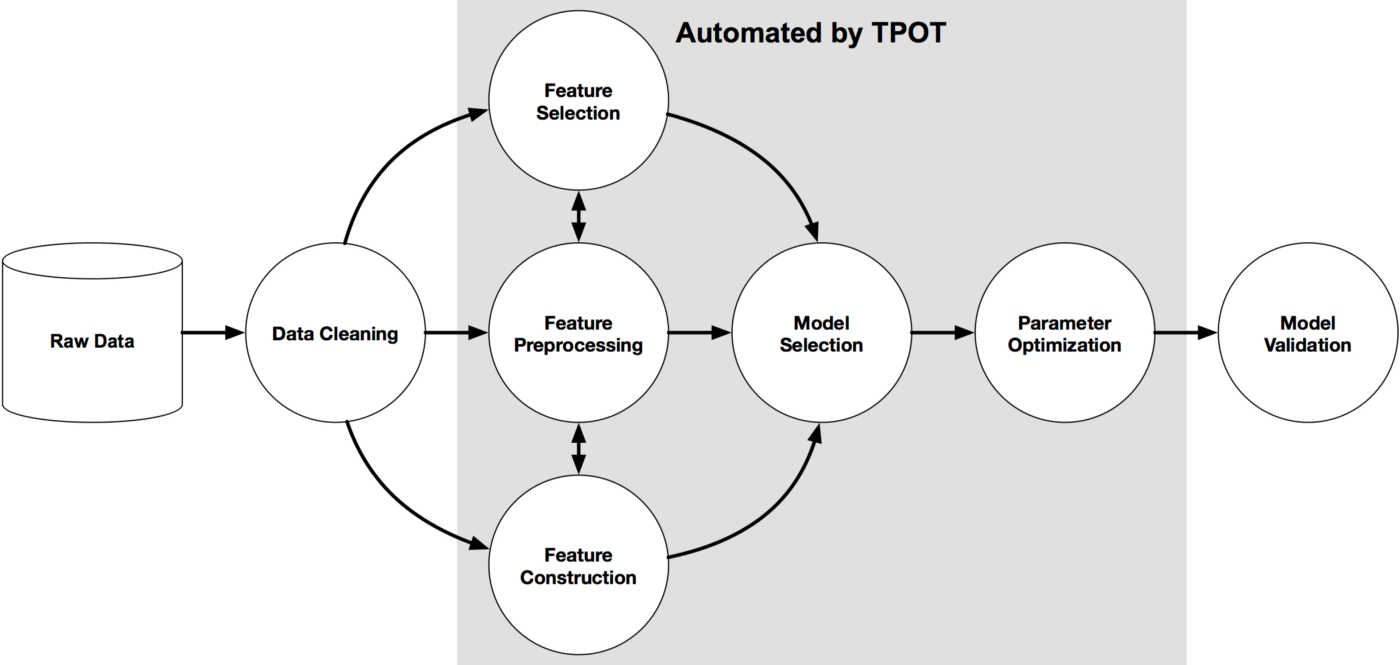

TPOT is built on the scikit learn library and follows the scikit learn API closely. It can be used for regression and classification tasks and has special implementations for medical research.

TPOT is open source, well documented, and under active development. It’s development was spearheaded by researchers at the University of Pennsylvania. TPOT appears to be one of the most popular autoML libraries, with nearly 4,500 GitHub stars as of August 2018.

### How does TPOT work?

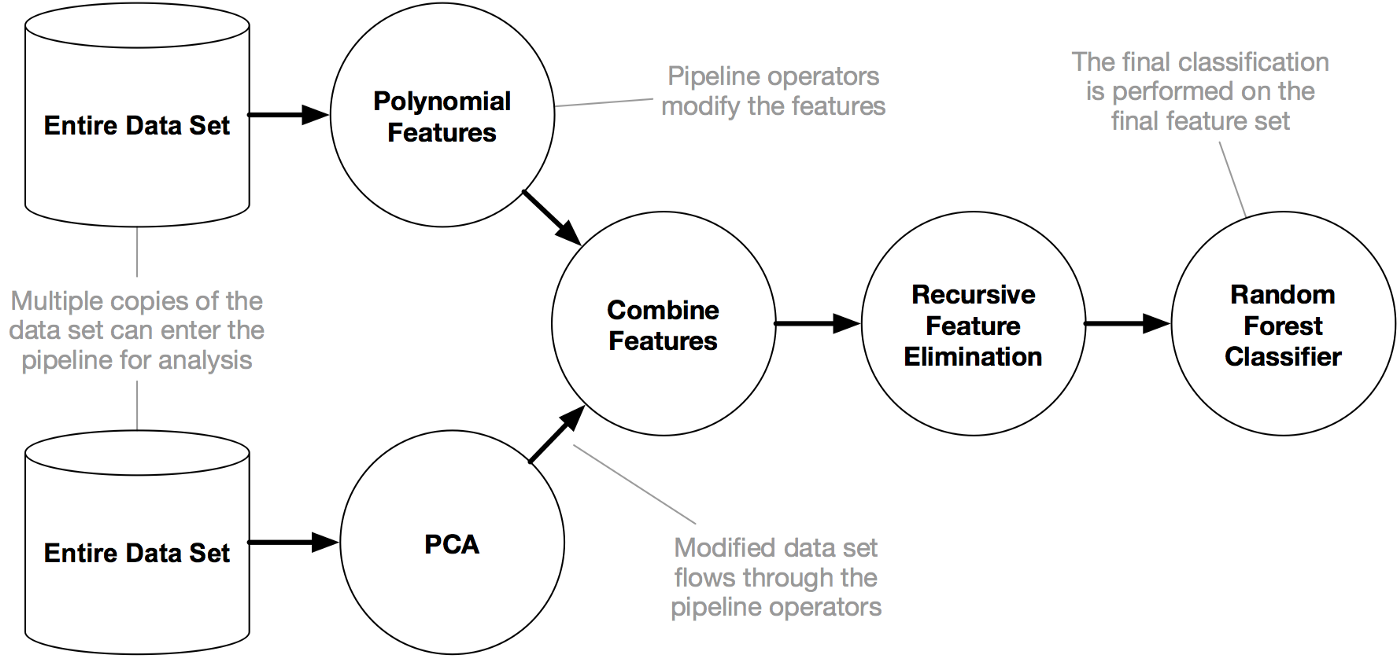

TPOT has what its developers call a genetic search algorithm to find the best parameters and model ensembles. It could also be thought of as a natural selection or evolutionary algorithm. TPOT tries a pipeline, evaluates its performance, and randomly changes parts of the pipeline in search of better performing algorithms.

AutoML algorithms aren’t as simple as fitting one model on the dataset; they are considering multiple machine learning algorithms (random forests, linear models, SVMs, etc.) in a pipeline with multiple preprocessing steps (missing value imputation, scaling, PCA, feature selection, etc.), the hyperparameters for all of the models and preprocessing steps, as well as multiple ways to ensemble or stack the algorithms within the pipeline. (source: TPOT docs)

This power of TPOT comes from evaluating all kinds of possible pipelines automatically and efficiently. Doing this manually is cumbersome and slower.

Running TPOT
Instantiating, fitting, and scoring the TPOT classifier is similar to any other sklearn classifier. Here’s the format:
```
tpot = TPOTClassifier()
tpot.fit(X_train, y_train)
tpot.score(X_test, y_test)
```
TPOT comes with its own variation of one-hot encoding. Note that it could add it to a pipeline automatically because it treats features with fewer than 10 unique values as categorical. If you want to use your own encoding strategy you can encode your data and then feed it into TPOT.
You can choose the scoring criterion for tpot.score (although a bug with Jupyter and multiple processor cores prevents you from having a custom scoring criterion with multiple processor cores in a Jupyter notebook).
It appears that you can’t alter the scoring criteria TPOT uses internally as it searches for the best pipeline, just the scoring criteria for use on the test set after TPOT has chosen the best algorithms. This is an area where some users might want more control. Perhaps this option will be added in a future version.
TPOT writes information about the best performing algorithm and it’s accuracy score to a file with tpot.export(). You can choose the level of verboseness you would like to see as TPOT runs and have it write pipelines to an output file as it runs in case it terminates early for some reason (e.g. your Kaggle Kernel crashes).

### How long does TPOT take to run?

The short answer is that it depends.
TPOT was designed to run for a while — hours or even a day. Although less complex problems with smaller datasets can see great results in minutes. You can adjust several parameters for TPOT to finish its searches faster, but at the expense of a less thorough search for an optimal pipeline. It was not designed to be a comprehensive search of preprocessing steps, feature selection, algorithms, and parameters, but it can come close if you set its parameters to be more exhaustive.
As the docs explain:

TPOT will take a while to run on larger datasets, but it’s important to realize why. With the default TPOT settings (100 generations with 100 population size), TPOT will evaluate 10,000 pipeline configurations before finishing. To put this number into context, think about a grid search of 10,000 hyperparameter combinations for a machine learning algorithm and how long that grid search will take. That is 10,000 model configurations to evaluate with 10-fold cross-validation, which means that roughly 100,000 models are fit and evaluated on the training data in one grid search.

Some of the data sets we’ll see below only need a few minutes to find algorithms that score well; others might need days.
Here are the default TPOTClassifier parameters:
```
generations=100, 
population_size=100, 
offspring_size=None  # Jeff notes this gets set to population_size
mutation_rate=0.9, 
crossover_rate=0.1, 
scoring="Accuracy",  # for Classification
cv=5, 
subsample=1.0, 
n_jobs=1,
max_time_mins=None, 
max_eval_time_mins=5,
random_state=None, 
config_dict=None,
warm_start=False, 
memory=None,
periodic_checkpoint_folder=None, 
early_stop=None
verbosity=0
disable_update_check=False
```
A description of each parameter can be found the docs. Here are a few key ones that determine the number of pipelines TPOT will search through:

* generations: int, optional (default: 100)           
    * Number of iterations to the run pipeline optimization process.            Generally, TPOT will work better when you give it more generations(and therefore time) to optimize the pipeline. 
    * TPOT will evaluate POPULATION_SIZE + GENERATIONS x OFFSPRING_SIZE pipelines in total (emphasis mine).
* population_size: int, optional (default: 100)            
    * Number of individuals to retain in the GP population every generation. 
    * Generally, TPOT will work better when you give it more individuals (and therefore time) to optimize the pipeline. 
* offspring_size: int, optional (default: None)
    * Number of offspring to produce in each GP generation.            
    * By default, offspring_size = population_size.
    
When starting out with TPOT it’s worth setting verbosity=3 and periodic_checkpoint_folder=“any_string_you_like” so that you can watch the models evolve and training scores improve. You’ll see some errors as some combinations of pipeline elements are incompatible, but don’t sweat that.

If you’re running on multiple cores and not using a custom scoring function, set n_jobs=-1 to use all available cores and speed up TPOT.

### Search Space

Here are the classification algorithms and parameters TPOT chooses from as of version 0.9:

* ‘sklearn.naive_bayes.BernoulliNB’: { ‘alpha’: [1e-3, 1e-2, 1e-1, 1., 10., 100.], ‘fit_prior’: [True, False] }, 
* ‘sklearn.naive_bayes.MultinomialNB’: { ‘alpha’: [1e-3, 1e-2, 1e-1, 1., 10., 100.], ‘fit_prior’: [True, False] }, 
* ‘sklearn.tree.DecisionTreeClassifier’: { ‘criterion’: [“gini”, “entropy”], ‘max_depth’: range(1, 11), ‘min_samples_split’: range(2, 21), ‘min_samples_leaf’: range(1, 21) }, 
* ‘sklearn.ensemble.ExtraTreesClassifier’: { ‘n_estimators’: [100], ‘criterion’: [“gini”, “entropy”], ‘max_features’: np.arange(0.05, 1.01, 0.05), ‘min_samples_split’: range(2, 21), ‘min_samples_leaf’: range(1, 21), ‘bootstrap’: [True, False] },
* ‘sklearn.ensemble.RandomForestClassifier’: { ‘n_estimators’: [100], ‘criterion’: [“gini”, “entropy”], ‘max_features’: np.arange(0.05, 1.01, 0.05), ‘min_samples_split’: range(2, 21), ‘min_samples_leaf’: range(1, 21), ‘bootstrap’: [True, False] }, 
* ‘sklearn.ensemble.GradientBoostingClassifier’: { ‘n_estimators’: [100], ‘learning_rate’: [1e-3, 1e-2, 1e-1, 0.5, 1.], ‘max_depth’: range(1, 11), ‘min_samples_split’: range(2, 21), ‘min_samples_leaf’: range(1, 21), ‘subsample’: np.arange(0.05, 1.01, 0.05), ‘max_features’: np.arange(0.05, 1.01, 0.05) },
* ‘sklearn.neighbors.KNeighborsClassifier’: { ‘n_neighbors’: range(1, 101), ‘weights’: [“uniform”, “distance”], ‘p’: [1, 2] }, 
* ‘sklearn.svm.LinearSVC’: { ‘penalty’: [“l1”, “l2”], ‘loss’: [“hinge”, “squared_hinge”], ‘dual’: [True, False], ‘tol’: [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], ‘C’: [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.] }, 
* ‘sklearn.linear_model.LogisticRegression’: { ‘penalty’: [“l1”, “l2”], ‘C’: [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.], ‘dual’: [True, False] }, 
* ‘xgboost.XGBClassifier’: { ‘n_estimators’: [100], ‘max_depth’: range(1, 11), ‘learning_rate’: [1e-3, 1e-2, 1e-1, 0.5, 1.], ‘subsample’: np.arange(0.05, 1.01, 0.05), ‘min_child_weight’: range(1, 21), ‘nthread’: [1] }

And TPOT can stack classifiers, including the same classifier multiple times. One of the core developers of TPOT explains how it works in this issue:

The pipeline ExtraTreesClassifier(ExtraTreesClassifier(input_matrix, True, 'entropy', 0.10000000000000001, 13, 6), True, 'gini', 0.75, 17, 4) does the following:
* Fit all of the original features using an ExtraTreesClassifier
* Take the predictions from that ExtraTreesClassifier and create a new feature using those predictions
* Pass the original features plus the new “predicted feature” to the 2nd ExtraTreesClassifier and use its predictions as the final predictions of the pipeline

This process is called stacking classifiers, which is a fairly common tactic in machine learning.

And here are the 11 preprocessors that could be applied by TPOT as of version 0.9.

* ‘sklearn.preprocessing.Binarizer’: { ‘threshold’: np.arange(0.0, 1.01, 0.05) }, 
* ‘sklearn.decomposition.FastICA’: { ‘tol’: np.arange(0.0, 1.01, 0.05) }, 
* ‘sklearn.cluster.FeatureAgglomeration’: { ‘linkage’: [‘ward’, ‘complete’, ‘average’], ‘affinity’: [‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’, ‘cosine’] }, 
* ‘sklearn.preprocessing.MaxAbsScaler’: { }, 
* ‘sklearn.preprocessing.MinMaxScaler’: { }, 
* ‘sklearn.preprocessing.Normalizer’: { ‘norm’: [‘l1’, ‘l2’, ‘max’] }, 
* ‘sklearn.kernel_approximation.Nystroem’: { ‘kernel’: [‘rbf’, ‘cosine’, ‘chi2’, ‘laplacian’, ‘polynomial’, ‘poly’, ‘linear’, ‘additive_chi2’, ‘sigmoid’], ‘gamma’: np.arange(0.0, 1.01, 0.05), ‘n_components’: range(1, 11) }, 
* ‘sklearn.decomposition.PCA’: { ‘svd_solver’: [‘randomized’], ‘iterated_power’: range(1, 11) }
* ‘sklearn.preprocessing.PolynomialFeatures’: { ‘degree’: [2], ‘include_bias’: [False], ‘interaction_only’: [False] }, 
* ‘sklearn.kernel_approximation.RBFSampler’: { ‘gamma’: np.arange(0.0, 1.01, 0.05) }, ‘sklearn.preprocessing.RobustScaler’: { }, 
* ‘sklearn.preprocessing.StandardScaler’: { }, ‘tpot.builtins.ZeroCount’: { }, 
* ‘tpot.builtins.OneHotEncoder’: { ‘minimum_fraction’: [0.05, 0.1, 0.15, 0.2, 0.25], ‘sparse’: [False] } (emphasis mine)

That’s a pretty comprehensive list of sklearn ml algorithms and even a few you might not have used for preprocessing, including Nystroem and RBFSampler. The final preprocessing algorithm listed is the custom OneHotEncoder mentioned before. Note that the list contains no neural network algorithms.

The number of combinations appears to be nearly infinite — you can stack algorithms, including instances of the same algorithm. There may be an internal cap on the number of steps in the pipeline, but suffice to say there are a plethora of possible pipelines.

TPOT will likely not result in the same algorithm selection if you run it twice (maybe not even if random_state is set, I found, as discussed below). As the docs explain:

If you’re working with a reasonably complex dataset or run TPOT for a short amount of time, different TPOT runs may result in different pipeline recommendations. TPOT’s optimization algorithm is stochastic in nature, which means that it uses randomness (in part) to search the possible pipeline space. When two TPOT runs recommend different pipelines, this means that the TPOT runs didn’t converge due to lack of time or that multiple pipelines perform more-or-less the same on your dataset.



In [3]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import timeit
import category_encoders
import os
from math import sqrt
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler, MinMaxScaler, LabelEncoder, normalize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,  cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer
from sklearn_pandas import CategoricalImputer
from tpot import TPOTRegressor

%matplotlib inline

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 300)

In [4]:
df = pd.read_csv("train.csv")
print(df.head())
print(df.info())
print(df.describe())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7          

In [6]:
# break into X and y dataframes
X = df.reindex(columns=[x for x in df.columns.values if x != 'SalePrice'])        # separate out X
y = df.reindex(columns=['SalePrice'])   # separate out y
y = np.ravel(y)                     # flatten the y array

# make list of numeric and string columns
numeric_cols = [] # could still have ordinal data
string_cols = []  # could have ordinal or nominal data

for col in X.columns:
    if (X.dtypes[col] == np.int64 or X.dtypes[col] == np.int32 or X.dtypes[col] == np.float64):
        numeric_cols.append(col)      # True integer or float columns
    
    if (X.dtypes[col] == np.object):  # Nominal and ordinal columns
        string_cols.append(col)


String column missing values were filled with a “missing” label prior to ordinal encoding because not all columns had a most frequent value. TPOT’s one hot encoding algorithm would then make one more dimension per feature that would indicate that the data had a missing value for that feature.

In [8]:
print(X[string_cols].head(2))

# impute missing values for string columns using sklearnpandas CategoricalImputer for string data
# s_imputer = CategoricalImputer(strategy="fixed_value", replacement="missing") 
# use above line as soon as sklearn-pandas updated
# s_imputer = CategoricalImputer()
X_string = X[string_cols]
# print(type(X_string))
# X_string = (s_imputer.fit_transform(X_string)

# or X_string = X_string.apply(s_imputer.fit_transform)

# X_string = pd.DataFrame(X_string, columns = string_cols)
print('fillna:')
X_string = X_string.fillna("missing")
print(X_string.head(2))

# encode the X columns string values as integers
print('LabelEncoder:')
X_string = X_string.apply(LabelEncoder().fit_transform)  
print(X_string.head(2))

  MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1       RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   

  Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl  \
0      CollgCr       Norm       Norm     1Fam     2Story     Gable  CompShg   
1      Veenker      Feedr       Norm     1Fam     1Story     Gable  CompShg   

  Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual  \
0     VinylSd     VinylSd    BrkFace        Gd        TA      PConc       Gd   
1     MetalSd     MetalSd       None        TA        TA     CBlock       Gd   

  BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC  \
0       TA           No          GLQ          Unf    GasA        Ex   
1       TA           Gd          ALQ          Unf    GasA        Ex   

  CentralAir Electrical KitchenQual Functional FireplaceQu GarageType  \

In [9]:
# imputing missing values with most freqent values for numeric columns
n_imputer = Imputer(missing_values='NaN', copy = True, strategy = 'most_frequent') # imputing with most frequent because some of these numeric columns are ordinal

X_numeric = X[numeric_cols]
X_numeric = n_imputer.fit_transform(X_numeric)
X_numeric = pd.DataFrame(X_numeric, columns = numeric_cols)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
# add the string and numeric dataframes back together
X = pd.concat([X_numeric, X_string], axis=1, join_axes=[X_numeric.index])

/home/ke/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
Id               1460 non-null float64
MSSubClass       1460 non-null float64
LotFrontage      1460 non-null float64
LotArea          1460 non-null float64
OverallQual      1460 non-null float64
OverallCond      1460 non-null float64
YearBuilt        1460 non-null float64
YearRemodAdd     1460 non-null float64
MasVnrArea       1460 non-null float64
BsmtFinSF1       1460 non-null float64
BsmtFinSF2       1460 non-null float64
BsmtUnfSF        1460 non-null float64
TotalBsmtSF      1460 non-null float64
1stFlrSF         1460 non-null float64
2ndFlrSF         1460 non-null float64
LowQualFinSF     1460 non-null float64
GrLivArea        1460 non-null float64
BsmtFullBath     1460 non-null float64
BsmtHalfBath     1460 non-null float64
FullBath         1460 non-null float64
HalfBath         1460 non-null float64
BedroomAbvGr     1460 non-null float64
KitchenAbvGr     1460 non-null floa

In [12]:
# convert to numpy array so that if gets XGBoost algorithm doesn't throw 
# ValueError: feature_names mismatch: ...
# I found I needed to convert my Pandas DataFrame to a Numpy Array to avoid an XGBoost issue on the regression task. This is a known issue with Pandas and XGBoost.
# see https://github.com/dmlc/xgboost/issues/2334
X = X.values

In [15]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 55)

In [18]:
%%time

# Make a custom metric function for TPOT
# Root mean squared logarithmic error is how Kaggle scores this task
# Can't use custom scorer with n_jobs > 1.  Known issue.

# def custom_rmsle(y_true, y_pred):
#     return np.sqrt(np.mean((np.log(1 + y_pred) - np.log(1 + y_true))**2))

# Make a custom scorer from the custom metric function
# rmsle = make_scorer(custom_rmsle, greater_is_better=False)

# Number of pipelines is very small below so that we can quickly commit on Kaggle

# instantiate tpot 
# number of pipelines = 80 + 20*80 = 1680
# number of pipelines = 10 + 5*10 = 60
tpot = TPOTRegressor(verbosity=3,  
                    random_state=55, 
                    #scoring=rmsle,
                    periodic_checkpoint_folder="intermediate_results",
                    n_jobs=-1, 
                    warm_start = True,
                    generations=5, 
                    population_size=10,
                    early_stop=8)
times = []
scores = []
winning_pipes = []

# run 2 iterations
for x in range(1):
    start_time = timeit.default_timer()
    tpot.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start_time
    times.append(elapsed)
    winning_pipes.append(tpot.fitted_pipeline_)
    scores.append(tpot.score(X_test, y_test))
    tpot.export('tpot_ames.py')


29 operators have been imported by TPOT.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 74.
Generation 1 - Current Pareto front scores:
-1	-832843188.6270168	LassoLarsCV(input_matrix, LassoLarsCV__normalize=True)

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Generation 2 - Current Pareto front scores:
-1	-832843188.6270168	LassoLarsCV(input_matrix, LassoLarsCV__normalize=True)

Saving periodic pipeline from pareto front to intermediate_results/pipeline_gen_2_idx_0_2020.05.20_01-29-57.py
Skipped pipeline #35 due to time out. Continuing to the next pipeline.
Generation 3 - Current Pareto front scores:
-1	-677589050.0774796	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=5, XGBRegressor__min_child_weight=14, XGBRegressor__n_estimators=100, XGBRegressor__nthread=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsa

In [19]:
# Turning on the GPU setting on Kaggle didn’t speed things up for most of these analyses, but likely would for deep learning.
# output results
times = [time/60 for time in times]
print('Times:', times)
print('Scores:', scores)   
print('Winning pipelines:', winning_pipes)

Times: [6.58752328999999]
Scores: [-1455911669.5620577]
Winning pipelines: [Pipeline(memory=None,
     steps=[('stackingestimator', StackingEstimator(estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=17, missing=No...tors=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])]


Those scores aren’t terrible. The output file from tpot.export from this small run is below.

```
import numpy as np 
import pandas as pd 
from sklearn.linear_model import ElasticNetCV, LassoLarsCV 
from sklearn.model_selection import train_test_split from sklearn.pipeline import make_pipeline, make_union 
from tpot.builtins import StackingEstimator  

# NOTE: Make sure that the class is labeled 'target' in the data file 
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64) 
features = tpot_data.drop('target', axis=1).values 

training_features, testing_features, training_target, testing_target = train_test_split(features, tpot_data['target'].values, random_state=42)  

# Score on the training set was:-0.169929041242275 
exported_pipeline = make_pipeline(     StackingEstimator(estimator=LassoLarsCV(normalize=False)),     ElasticNetCV(l1_ratio=0.75, tol=0.01) 
exported_pipeline.fit(training_features, training_target) 
results = exported_pipeline.predict(testing_features)
```